# Testing numerical matrix generation

## -- LUVOIR --

In [51]:
# Imports
import os
import time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import hcipy as hc
os.chdir('../../pastis/')
from config import CONFIG_INI
import util_pastis as util
from e2e_simulators.luvoir_imaging import SegmentedTelescopeAPLC

### Parameters

In [52]:
# System parameters
resDir = os.path.join(CONFIG_INI.get('local', 'local_data_path'), 'active', 'matrix_numerical')
datadir = '/Users/pueyo/PythonPackage/PASTIS/LUVOIR_delivery_May2019/'
zern_number = CONFIG_INI.getint('calibration', 'zernike')
zern_mode = util.ZernikeMode(zern_number)                       # Create Zernike mode object for easier handling

# General telescope parameters - I could import this from the configfile
nb_seg = 120
wvln = 638e-9  # m
diam = 15.  # m
nm_aber = 1e-9   # m

# Image system parameters
im_lamD = 30  # image size in lambda/D
sampling = 4

# Coronagraph parameters
# The LUVOIR STDT delivery in May 2018 included three different apodizers
# we can work with, so I will implement an easy way of making a choice between them.
design = 'medium'
datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
apod_dict = {'small': {'pxsize': 1000, 'fpm_rad': 3.5, 'fpm_px': 150, 'iwa': 3.4, 'owa': 12.,
                       'fname': '0_LUVOIR_N1000_FPM350M0150_IWA0340_OWA01200_C10_BW10_Nlam5_LS_IDD0120_OD0982_no_ls_struts.fits'},
             'medium': {'pxsize': 1000, 'fpm_rad': 6.82, 'fpm_px': 250, 'iwa': 6.72, 'owa': 23.72,
                        'fname': '0_LUVOIR_N1000_FPM682M0250_IWA0672_OWA02372_C10_BW10_Nlam5_LS_IDD0120_OD0982_no_ls_struts.fits'},
             'large': {'pxsize': 1000, 'fpm_rad': 13.38, 'fpm_px': 400, 'iwa': 13.28, 'owa': 46.88,
                       'fname': '0_LUVOIR_N1000_FPM1338M0400_IWA1328_OWA04688_C10_BW10_Nlam5_LS_IDD0120_OD0982_no_ls_struts.fits'}}

pup_px = apod_dict[design]['pxsize']
fpm_rad = apod_dict[design]['fpm_rad']  # lambda/D
fpm_px = apod_dict[design]['fpm_px']
samp_foc = fpm_px / (fpm_rad * 2)  # sampling of focal plane mask
iwa = apod_dict[design]['iwa']  # lambda/D
owa = apod_dict[design]['owa']  # lambda/D

# Print some of the defined parameters
print('LUVOIR apodizer design: {}'.format(design))
print()
print('Wavelength: {} m'.format(wvln))
print('Telescope diameter: {} m'.format(diam))
print('Number of segments: {}'.format(nb_seg))
print()
print('IWA: {} lambda/D'.format(iwa))
print('OWA: {} lambda/D'.format(owa))
print('Pupil size: {} pixels'.format(pup_px))
print('Image size: {} lambda/D'.format(im_lamD))
print('Sampling: {} px per lambda/D'.format(sampling))
print('FPM radius: {} lambda/D'.format(fpm_rad))
print('Pixels in FPM: {} pixels'.format(fpm_px))

LUVOIR apodizer design: medium

Wavelength: 6.38e-07 m
Telescope diameter: 15.0 m
Number of segments: 120

IWA: 6.72 lambda/D
OWA: 23.72 lambda/D
Pupil size: 1000 pixels
Image size: 30 lambda/D
Sampling: 4 px per lambda/D
FPM radius: 6.82 lambda/D
Pixels in FPM: 250 pixels


### Setting up the paths

In [55]:
# If subfolder "matrix_numerical" doesn't exist yet, create it.
if os.path.isdir(resDir) == False:
    #os.mkdir(resDir)
    os.mkdir('/Users/pueyo/Documents/data_from_repos/pastis_data/active/matrix_numerical')

# If subfolder "OTE_images" doesn't exist yet, create it.
if not os.path.isdir(os.path.join(resDir, 'OTE_images')):
    os.mkdir(os.path.join(resDir, 'OTE_images'))

# If subfolder "psfs" doesn't exist yet, create it.
if not os.path.isdir(os.path.join(resDir, 'psfs')):
    os.mkdir(os.path.join(resDir, 'psfs'))

### Preparing the optical elements

In [56]:
# Pupil plane optics
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
apod_path = os.path.join(datadir, 'luvoir_stdt_baseline_bw10', design + '_fpm', 'solutions',
                         apod_dict[design]['fname'])
ls_fname = 'inputs/LS_LUVOIR_ID0120_OD0982_no_struts_gy_ovsamp4_N1000.fits'

pup_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))
apod_read = hc.read_fits(os.path.join(datadir, apod_path))
ls_read = hc.read_fits(os.path.join(datadir, ls_fname))

# Cast the into Fields on a pupil plane grid
pupil_grid = hc.make_pupil_grid(dims=pup_px, diameter=diam)

aperture = hc.Field(pup_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)
apod = hc.Field(apod_read.ravel(), pupil_grid)
ls = hc.Field(ls_read.ravel(), pupil_grid)

### Segment positions

# Load segment positions form fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nb_seg):
    segname = 'SEG' + str(i + 1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))

poslist = np.transpose(np.array(poslist))

# Cast into HCIPy CartesianCoordinates (because that's what the SM needs)
seg_pos = hc.CartesianGrid(poslist)

### Focal plane mask

# Make focal grid for FPM
focal_grid_fpm = hc.make_focal_grid(pupil_grid=pupil_grid, q=samp_foc, num_airy=fpm_rad, wavelength=wvln)

# Also create detector plane focal grid
focal_grid_det = hc.make_focal_grid(pupil_grid=pupil_grid, q=sampling, num_airy=im_lamD, wavelength=wvln)

# Let's figure out how much 1 lambda/D is in radians (needed for focal plane)
lam_over_d = wvln / diam  # rad

# Create FPM on a focal grid, with radius in lambda/D
fpm = 1 - hc.circular_aperture(2 * fpm_rad * lam_over_d)(focal_grid_fpm)

### Telescope simulator

In [57]:
# Create parameter dictionary
luvoir_params = {'wavelength': wvln, 'diameter': diam, 'imlamD': im_lamD, 'fpm_rad': fpm_rad}

# Instantiate LUVOIR telescope with APLC
luvoir = SegmentedTelescopeAPLC(aperture, aper_ind, seg_pos, apod, ls, fpm, focal_grid_det, luvoir_params)

### Dark hole mask
dh_outer = hc.circular_aperture(2 * owa * lam_over_d)(focal_grid_det)
dh_inner = hc.circular_aperture(2 * iwa * lam_over_d)(focal_grid_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

### Reference image for contrast normalization
_im, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)

## Generating numerical PASTIS matrix

In [58]:
image

In [63]:
inter['seg_mirror']

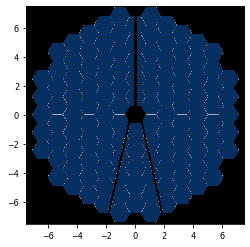

In [77]:
hc.imshow_field(inter['seg_mirror'].intensity, mask=aperture, cmap='RdBu')

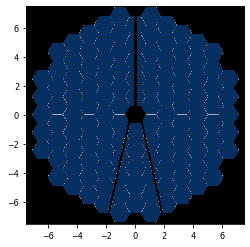

In [76]:
hc.imshow_field((inter['seg_mirror'].amplitude)**2, mask=aperture, cmap='RdBu')

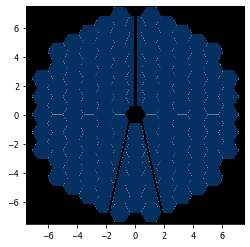

In [65]:
hc.imshow_field(inter['seg_mirror'].real, mask=aperture, cmap='RdBu')

nm_aber: 1e-09 m

STEP: 1-1 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 5192420.442639491

STEP: 1-2 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 7671808.901875825

STEP: 1-3 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 7699094.785692477

STEP: 2-1 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 7671808.901875825

STEP: 2-2 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 5000812.824930951

STEP: 2-3 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 6481440.7989272615

STEP: 3-1 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 7699094.785692477

STEP: 3-2 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 6481440.7989272615

STEP: 3-3 / 3-3
Calculating coro image...
Calculating mean contrast in dark hole
contrast: 3266344.9

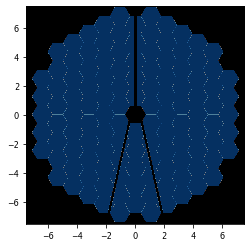

In [80]:
# Reduce the number of segments for testing purposes
nb_seg = 3
savestuff = False  # in case I don't actually want to save anything to disk

# Generating the PASTIS matrix and a list for all contrasts
matrix_direct = np.zeros([nb_seg, nb_seg])   # Generate empty matrix
all_psfs = []
all_contrasts = []

print('nm_aber: {} m'.format(nm_aber))

for i in range(nb_seg):
    for j in range(nb_seg):

        print('\nSTEP: {}-{} / {}-{}'.format(i+1, j+1, nb_seg, nb_seg))

        # Put aberration on correct segments. If i=j, apply only once!
        luvoir.flatten()
        luvoir.set_segment(i+1, nm_aber/2, 0, 0)
        if i != j:
            luvoir.set_segment(j+1, nm_aber/2, 0, 0)

        print('Calculating coro image...')
        #image, inter = luvoir.calc_psf(ref=False, display_intermediate=False, return_intermediate=True)
        image, inter = luvoir.calc_psf(ref=False, display_intermediate=False, return_intermediate='efield')
        # Normalize PSF by reference image
        psf = image.intensity

        # Save image to disk
        filename_psf = 'psf_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index) + '_segs_' + str(i+1) + '-' + str(j+1)
        if savestuff:
            hc.write_fits(psf, os.path.join(resDir, 'psfs', filename_psf + '.fits'))
        all_psfs.append(psf)

        # Save OPD images for testing (are these actually surface images, not OPD?)
        opd_name = 'opd_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index) + '_segs_' + str(
            i + 1) + '-' + str(j + 1)
        plt.clf()
        hc.imshow_field(inter['seg_mirror'].amplitude, mask=aperture, cmap='RdBu')
        if savestuff:
            plt.savefig(os.path.join(resDir, 'OTE_images', opd_name + '.pdf'))

        print('Calculating mean contrast in dark hole')
        dh_intensity = psf * dh_mask
        contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
        print('contrast:', contrast)
        all_contrasts.append(contrast)

        # Fill according entry in the matrix
        matrix_direct[i,j] = contrast

# Filling the off-axis elements
matrix_two_N = np.copy(matrix_direct)      # This is just an intermediary copy so that I don't mix things up.
matrix_pastis = np.copy(matrix_direct)     # This will be the final PASTIS matrix.

print()
for i in range(nb_seg):
    for j in range(nb_seg):
        if i != j:
            matrix_off_val = (matrix_two_N[i,j] - matrix_two_N[i,i] - matrix_two_N[j,j]) / 2.
            matrix_pastis[i,j] = matrix_off_val
            print('Off-axis for i{}-j{}: {}'.format(i+1, j+1, matrix_off_val))

# Normalize matrix for the input aberration
matrix_pastis /= np.square(nm_aber)

# Save matrix to file
if savestuff:
    filename_matrix = 'PASTISmatrix_num_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index)
    hc.write_fits(matrix_pastis, os.path.join(resDir, filename_matrix + '.fits'))
    print('Matrix saved to:', os.path.join(resDir, filename_matrix + '.fits'))

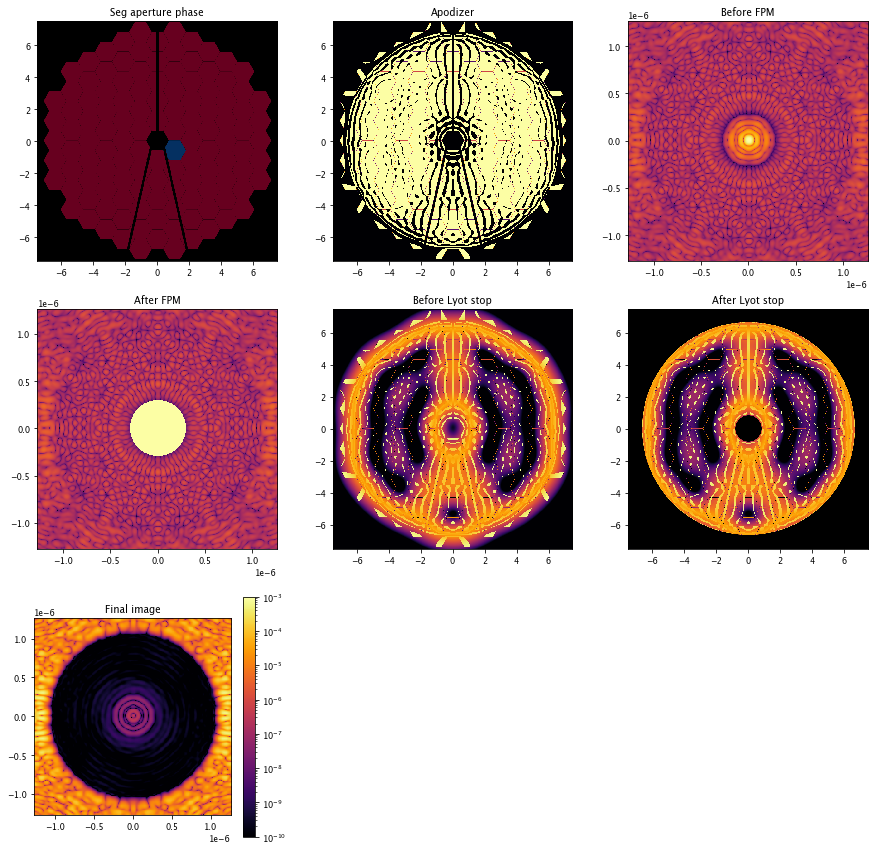

In [30]:
ho,ha = luvoir.calc_psf(ref=True, display_intermediate=True, return_intermediate=True)

In [28]:
ho.wf_im_coro

AttributeError: 'tuple' object has no attribute 'wf_im_coro'

In [25]:
?luvoir.calc_psf

In [36]:
?luvoir.set_segment